In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from tqdm import tqdm

from collections import OrderedDict

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device : {device}')

Using device : cuda


<h3>Load and Preprocess Dataset</h3>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
prepend = '/content/drive/MyDrive/Datasets/brain mri/'

In [5]:
imgSize = 112

# Training transformer
trainTransformer = transforms.Compose([
    transforms.RandomRotation(degrees = 20),

    transforms.RandomHorizontalFlip(p = 0.3),
    transforms.RandomVerticalFlip(p = 0.3),

    transforms.Resize(size = (imgSize, imgSize), antialias = True),
    transforms.CenterCrop(size = (imgSize, imgSize)),

    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

# Validation transformer
valTransformer = transforms.Compose([
    transforms.Resize(size = (imgSize, imgSize), antialias = True),
    transforms.CenterCrop(size = (imgSize, imgSize)),

    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

In [6]:
trainPath = prepend+'Training/'
valPath = prepend+'Testing/'

trainData = datasets.ImageFolder(root=trainPath, transform=trainTransformer)
valData = datasets.ImageFolder(root=trainPath, transform=valTransformer)

In [7]:
trainData.classes

['glioma', 'meningioma', 'notumor', 'pituitary']

In [8]:
trainLoader = DataLoader(dataset=trainData, shuffle=True, batch_size=256)
valLoader = DataLoader(dataset=valData, shuffle=True, batch_size=256)

In [9]:
resnet = models.resnet50(weights=True)
print(resnet)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 155MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

<p><b>Customise Model</b></p>

In [10]:
# replace final Linear layer with Log Softmax layer for multi-class classification
print('Original Final Layer')
print(resnet.fc)

# build custom classifier
num_classes = 4
num_ftrs = resnet.fc.in_features
classifier = nn.Sequential(
    OrderedDict(
        [
            ('fc', nn.Linear(num_ftrs, num_classes)),
            ('output', nn.LogSoftmax(dim=1))
        ]
    )
)
resnet.fc = classifier

print('\nModified Final Layer')
print(resnet.fc)

Original Final Layer
Linear(in_features=2048, out_features=1000, bias=True)

Modified Final Layer
Sequential(
  (fc): Linear(in_features=2048, out_features=4, bias=True)
  (output): LogSoftmax(dim=1)
)


In [11]:
resnet.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

**Train Model**

In [12]:
# parameters
epochs = 30
criterion = nn.NLLLoss()
optimizer = optim.Adam(resnet.fc.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

# early stopper
minDelta = 0.01
patience = 5
currentPatience = 0
bestLoss = float('inf')

In [13]:
plot_training = []
plot_validation = []
plot_accuracy = []

for epoch in range(epochs):
    print(f'EPOCH: {epoch+1}/{epochs}')
    resnet.train()
    running_loss = 0

    for images, labels in tqdm(trainLoader, total=len(trainLoader)):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        pred_prob = resnet.forward(images)
        loss = criterion(pred_prob, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # evaluate performance of each epoch
    resnet.eval()

    # turn off gradient for validation
    with torch.no_grad():
        val_loss = 0
        correct = total = 0
        accuracy = 0

        for images, labels in iter(valLoader):
            images, labels = images.to(device), labels.to(device)
            pred_prob = resnet.forward(images)
            val_loss += criterion(pred_prob, labels).item()

            probabilities = torch.exp(pred_prob)
            pred = labels.data == probabilities.max(dim=1)[1]
            total += labels.size(0)
            correct += (pred).sum().item()

        accuracy = correct/total *100
        print(f'Training Loss: {round(running_loss, 3)}')
        print(f'Validation Loss: {round(val_loss, 3)}')

        print(f'Validation Accuracy: {accuracy}')
        scheduler.step(val_loss)

        plot_training.append(running_loss)
        plot_validation.append(val_loss)
        plot_accuracy.append(accuracy)

        # early stopping
        if val_loss < bestLoss - minDelta:
            bestLoss = val_loss
            currentPatience = 0
        else:
            currentPatience += 1
            if currentPatience >= patience:
                print('Early stopping triggered!')
                break


EPOCH: 1/30


100%|██████████| 23/23 [30:13<00:00, 78.86s/it]


Training Loss: 21.45
Validation Loss: 15.427
Validation Accuracy: 76.10294117647058
EPOCH: 2/30


100%|██████████| 23/23 [00:56<00:00,  2.47s/it]


Training Loss: 13.432
Validation Loss: 12.663
Validation Accuracy: 80.67226890756302
EPOCH: 3/30


100%|██████████| 23/23 [00:57<00:00,  2.49s/it]


Training Loss: 11.641
Validation Loss: 11.069
Validation Accuracy: 83.2107843137255
EPOCH: 4/30


100%|██████████| 23/23 [00:56<00:00,  2.47s/it]


Training Loss: 10.784
Validation Loss: 10.382
Validation Accuracy: 83.50840336134453
EPOCH: 5/30


100%|██████████| 23/23 [00:57<00:00,  2.50s/it]


Training Loss: 10.412
Validation Loss: 9.831
Validation Accuracy: 84.99649859943978
EPOCH: 6/30


100%|██████████| 23/23 [00:56<00:00,  2.47s/it]


Training Loss: 9.709
Validation Loss: 9.375
Validation Accuracy: 85.76680672268907
EPOCH: 7/30


100%|██████████| 23/23 [00:56<00:00,  2.46s/it]


Training Loss: 9.546
Validation Loss: 9.148
Validation Accuracy: 85.85434173669468
EPOCH: 8/30


100%|██████████| 23/23 [00:57<00:00,  2.50s/it]


Training Loss: 8.995
Validation Loss: 8.653
Validation Accuracy: 86.92226890756302
EPOCH: 9/30


100%|██████████| 23/23 [00:56<00:00,  2.47s/it]


Training Loss: 9.052
Validation Loss: 8.576
Validation Accuracy: 86.88725490196079
EPOCH: 10/30


100%|██████████| 23/23 [00:57<00:00,  2.49s/it]


Training Loss: 8.944
Validation Loss: 8.282
Validation Accuracy: 87.57002801120449
EPOCH: 11/30


100%|██████████| 23/23 [00:56<00:00,  2.47s/it]


Training Loss: 8.653
Validation Loss: 8.246
Validation Accuracy: 87.79761904761905
EPOCH: 12/30


100%|██████████| 23/23 [00:56<00:00,  2.47s/it]


Training Loss: 8.351
Validation Loss: 8.082
Validation Accuracy: 87.3249299719888
EPOCH: 13/30


100%|██████████| 23/23 [00:57<00:00,  2.50s/it]


Training Loss: 8.396
Validation Loss: 7.795
Validation Accuracy: 87.79761904761905
EPOCH: 14/30


100%|██████████| 23/23 [00:56<00:00,  2.46s/it]


Training Loss: 8.491
Validation Loss: 7.852
Validation Accuracy: 87.81512605042016
EPOCH: 15/30


100%|██████████| 23/23 [00:56<00:00,  2.45s/it]


Training Loss: 8.259
Validation Loss: 7.721
Validation Accuracy: 88.72549019607843
EPOCH: 16/30


100%|██████████| 23/23 [00:55<00:00,  2.43s/it]


Training Loss: 8.089
Validation Loss: 7.588
Validation Accuracy: 88.74299719887955
EPOCH: 17/30


100%|██████████| 23/23 [00:56<00:00,  2.45s/it]


Training Loss: 8.134
Validation Loss: 7.533
Validation Accuracy: 88.16526610644257
EPOCH: 18/30


100%|██████████| 23/23 [00:55<00:00,  2.42s/it]


Training Loss: 7.786
Validation Loss: 7.269
Validation Accuracy: 88.56792717086834
EPOCH: 19/30


100%|██████████| 23/23 [00:56<00:00,  2.46s/it]


Training Loss: 7.764
Validation Loss: 7.729
Validation Accuracy: 87.37745098039215
EPOCH: 20/30


100%|██████████| 23/23 [00:56<00:00,  2.46s/it]


Training Loss: 8.006
Validation Loss: 7.501
Validation Accuracy: 88.28781512605042
EPOCH: 21/30


100%|██████████| 23/23 [00:56<00:00,  2.45s/it]


Training Loss: 7.585
Validation Loss: 7.106
Validation Accuracy: 88.84803921568627
EPOCH: 22/30


100%|██████████| 23/23 [00:56<00:00,  2.45s/it]


Training Loss: 7.656
Validation Loss: 7.985
Validation Accuracy: 86.39705882352942
EPOCH: 23/30


100%|██████████| 23/23 [00:56<00:00,  2.45s/it]


Training Loss: 8.031
Validation Loss: 6.817
Validation Accuracy: 89.56582633053222
EPOCH: 24/30


100%|██████████| 23/23 [00:57<00:00,  2.48s/it]


Training Loss: 7.543
Validation Loss: 7.27
Validation Accuracy: 88.56792717086834
EPOCH: 25/30


100%|██████████| 23/23 [00:56<00:00,  2.44s/it]


Training Loss: 7.452
Validation Loss: 6.733
Validation Accuracy: 89.82843137254902
EPOCH: 26/30


100%|██████████| 23/23 [00:56<00:00,  2.44s/it]


Training Loss: 7.331
Validation Loss: 6.904
Validation Accuracy: 89.16316526610645
EPOCH: 27/30


100%|██████████| 23/23 [00:56<00:00,  2.44s/it]


Training Loss: 7.253
Validation Loss: 6.841
Validation Accuracy: 89.82843137254902
EPOCH: 28/30


100%|██████████| 23/23 [00:56<00:00,  2.46s/it]


Training Loss: 7.444
Validation Loss: 6.664
Validation Accuracy: 89.88095238095238
EPOCH: 29/30


100%|██████████| 23/23 [00:56<00:00,  2.45s/it]


Training Loss: 7.251
Validation Loss: 6.743
Validation Accuracy: 89.79341736694678
EPOCH: 30/30


100%|██████████| 23/23 [00:55<00:00,  2.42s/it]


Training Loss: 7.337
Validation Loss: 6.595
Validation Accuracy: 90.24859943977592


<h3>Visualisation</h3>

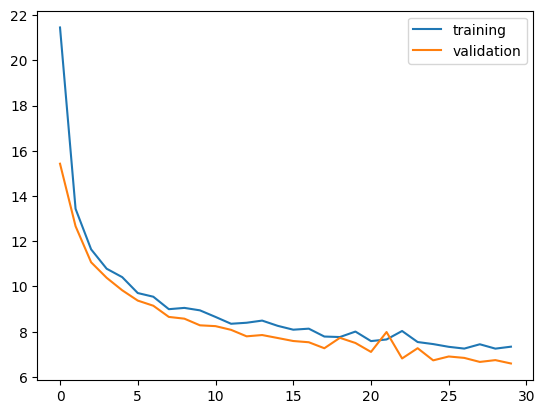

In [14]:
plt.plot(range(len(plot_training)), plot_training, label='training')
plt.plot(range(len(plot_validation)), plot_validation, label='validation')
plt.legend()
plt.show()

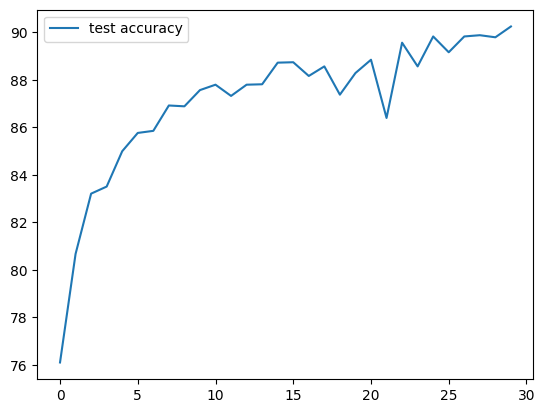

In [15]:
plt.plot(range(len(plot_accuracy)), plot_accuracy, label='test accuracy')
plt.legend()
plt.show()